In [1]:
import pandas as pd
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Docker Compose 환경 변수에서 DB 접속 정보 읽기
# Airflow 컨테이너 내부이므로, settings.py 대신 os.environ 직접 사용 가능
db_user = os.environ.get("POSTGRES_USER", "crypto")
db_password = os.environ.get("POSTGRES_PASSWORD", "crypto")
db_host = "postgres" # docker-compose.yml의 서비스 이름 사용
db_name = os.environ.get("POSTGRES_DB", "cryptoflow")

# SQLAlchemy를 사용하여 PostgreSQL 연결 엔진 생성
engine = create_engine(f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:5432/{db_name}")

print("PostgreSQL 연결 성공!")

# 데이터 마트 테이블에서 모든 데이터 불러오기
sql_query = "SELECT * FROM market_stats_24h ORDER BY ts_event DESC"
df = pd.read_sql(sql_query, engine, index_col='id', parse_dates=['ts_event', 'created_at'])

print(f"데이터 로드 완료: {len(df)} 행")

# 데이터 기본 정보 확인
print("\n--- 데이터 기본 정보 (info) ---")
df.info()

print("\n--- 데이터 통계 요약 (describe) ---")
print(df.describe())

print("\n--- 데이터 샘플 확인 (head) ---")
print(df.head())

# 시각화 설정 (선택 사항)
# plt.style.use('ggplot')
# sns.set(rc={'figure.figsize':(15, 5)})

# # 예시: KRW-BTC의 24시간 거래대금 시계열 그래프
# df_btc = df[df['symbol'] == 'KRW-BTC']
# if not df_btc.empty:
#     plt.figure(figsize=(15, 5))
#     sns.lineplot(data=df_btc, x='ts_event', y='acc_trade_price_24h')
#     plt.title('KRW-BTC 24hr Accumulated Trade Price Over Time')
#     plt.xlabel('Timestamp')
#     plt.ylabel('Accumulated Trade Price (24h)')
#     plt.show()

PostgreSQL 연결 성공!
데이터 로드 완료: 10750 행

--- 데이터 기본 정보 (info) ---
<class 'pandas.core.frame.DataFrame'>
Index: 10750 entries, 795477 to 784929
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   symbol                10750 non-null  object             
 1   acc_trade_price_24h   10750 non-null  float64            
 2   acc_trade_volume_24h  10750 non-null  float64            
 3   source                10750 non-null  object             
 4   ts_event              10750 non-null  datetime64[ns, UTC]
 5   created_at            10750 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(2), object(2)
memory usage: 587.9+ KB

--- 데이터 통계 요약 (describe) ---
       acc_trade_price_24h  acc_trade_volume_24h
count         1.075000e+04          1.075000e+04
mean          2.534662e+10          2.450548e+10
std           9.365033e+10          2.122553e+11
min           2.2946

DETAIL:  The database was created using collation version 2.36, but the operating system provides version 2.41.
HINT:  Rebuild all objects in this database that use the default collation and run ALTER DATABASE cryptoflow REFRESH COLLATION VERSION, or build PostgreSQL with the right library version.


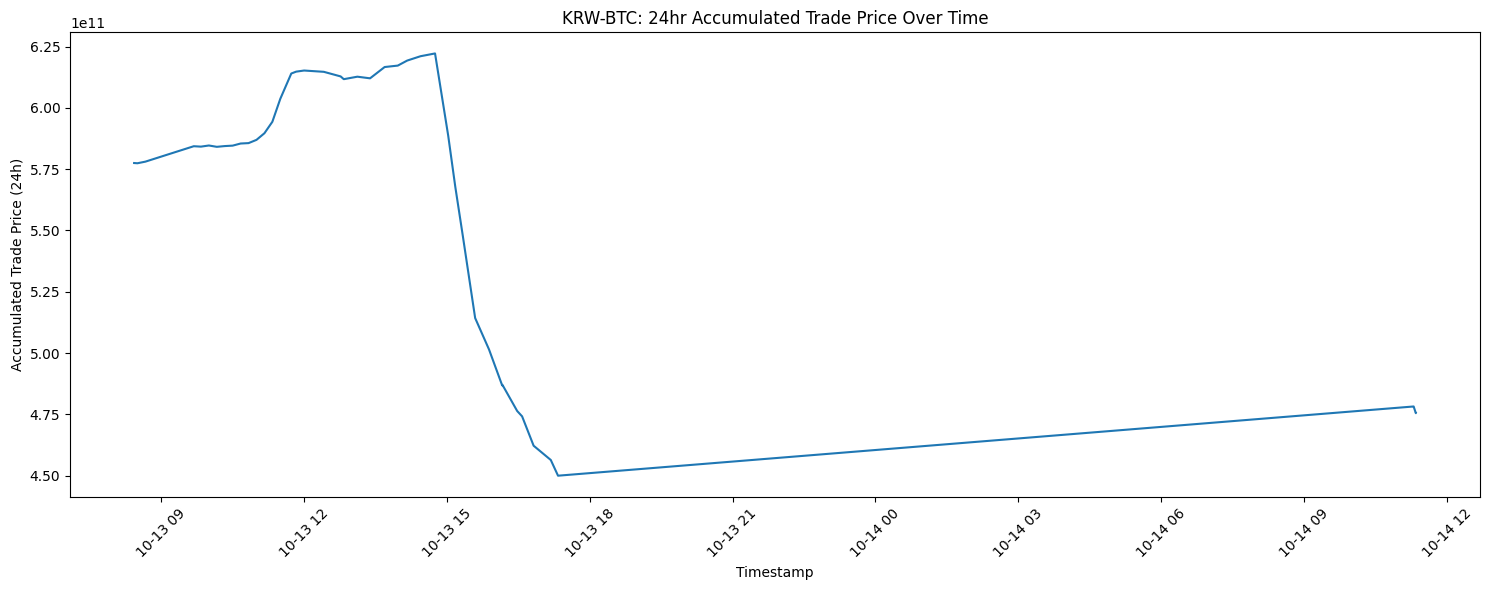


--- KRW-BTC Data (with Moving Average) ---
                        ts_event  acc_trade_price_24h  acc_trade_price_24h_MA5
id                                                                            
794629 2025-10-13 17:20:00+00:00   449,956,549,382.80       459,807,234,708.02
794844 2025-10-14 11:18:07+00:00   478,188,216,293.45       460,612,515,412.35
795059 2025-10-14 11:18:17+00:00   478,192,940,305.08       463,814,212,393.08
795274 2025-10-14 11:21:02+00:00   475,452,299,741.08       467,631,336,742.89
795489 2025-10-14 11:21:08+00:00   475,582,422,934.48       471,474,485,731.38


In [11]:
# Filter for KRW-BTC data only
df_btc = df[df['symbol'] == 'KRW-BTC'].sort_values('ts_event')

# Time series data visualization (24-hour accumulated trade price)
if not df_btc.empty:
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_btc, x='ts_event', y='acc_trade_price_24h')
    plt.title('KRW-BTC: 24hr Accumulated Trade Price Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Accumulated Trade Price (24h)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No KRW-BTC data found.")

# Simple feature engineering example: Calculate 5-period moving average
if len(df_btc) > 5:
    df_btc['acc_trade_price_24h_MA5'] = df_btc['acc_trade_price_24h'].rolling(window=5).mean()

    # --- Pandas 출력 형식을 float으로 설정 ---
    # 데이터프레임을 출력하기 전에 float 형식을 지정합니다.
    # 소수점 아래 2자리까지, 천 단위 콤마를 포함하여 표시합니다.
    pd.options.display.float_format = '{:,.2f}'.format
    # ----------------------------------------

    print("\n--- KRW-BTC Data (with Moving Average) ---")
    # 이제 이 print 문은 위에서 설정한 float 형식을 따르게 됩니다.
    print(df_btc[['ts_event', 'acc_trade_price_24h', 'acc_trade_price_24h_MA5']].tail())

In [17]:
# --- 피처 엔지니어링 ---

# 1. 이동 평균 (Moving Averages)
# window 크기를 리스트로 정의하여 여러 이동평균을 한 번에 계산
ma_windows = [5, 10, 20]
for window in ma_windows:
    df_btc[f'price_MA{window}'] = df_btc['acc_trade_price_24h'].rolling(window=window).mean()
    df_btc[f'volume_MA{window}'] = df_btc['acc_trade_volume_24h'].rolling(window=window).mean()

# 2. 변동률 (Rate of Change)
# periods를 리스트로 정의하여 여러 기간의 변동률을 계산
roc_periods = [1, 3, 5]
for period in roc_periods:
    # (현재 값 - period 전 값) / period 전 값
    df_btc[f'price_RoC{period}'] = df_btc['acc_trade_price_24h'].pct_change(periods=period) * 100 # 백분율로 표시

# 3. 시간 관련 피처 (Time-based Features)
# 'ts_event' 컬럼이 datetime 타입이어야 함 (이전 단계에서 parse_dates로 변환했음)
df_btc['hour_of_day'] = df_btc['ts_event'].dt.hour
df_btc['day_of_week'] = df_btc['ts_event'].dt.dayofweek # 월요일=0, 일요일=6

# 4. 지연된 값 (Lagged Features)
# periods를 리스트로 정의하여 여러 기간의 지연 값 생성
lag_periods = [1, 2, 3]
for lag in lag_periods:
    df_btc[f'price_lag{lag}'] = df_btc['acc_trade_price_24h'].shift(lag)
    df_btc[f'volume_lag{lag}'] = df_btc['acc_trade_volume_24h'].shift(lag)

# --- 결과 확인 ---
# 생성된 피처들과 NaN 값 확인 (이동평균, 변동률, 지연 값은 초기 데이터에 NaN이 발생함)
print("\n--- 생성된 피처 확인 (마지막 10개 행) ---")
# 소수점 2자리까지만 보이도록 설정 (선택 사항)
# pd.options.display.float_format = '{:,.2f}'.format 
print(df_btc.tail(10))

print("\n--- 각 피처별 NaN 값 개수 ---")
print(df_btc.isnull().sum())

# NaN 값이 있는 행 제거 (모델 학습 전에는 NaN 처리 필수)
df_btc_cleaned = df_btc.dropna()
print(f"\nNaN 제거 후 데이터 크기: {len(df_btc_cleaned)}")


--- 생성된 피처 확인 (마지막 10개 행) ---
         symbol  acc_trade_price_24h  acc_trade_volume_24h source  \
id                                                                  
793554  KRW-BTC   476,340,804,463.40              2,750.00  upbit   
793769  KRW-BTC   474,161,812,771.82              2,737.38  upbit   
793984  KRW-BTC   462,184,455,401.44              2,667.96  upbit   
794414  KRW-BTC   456,366,677,992.04              2,634.25  upbit   
794312  KRW-BTC   456,366,677,992.04              2,634.25  upbit   
794629  KRW-BTC   449,956,549,382.80              2,597.02  upbit   
794844  KRW-BTC   478,188,216,293.45              2,803.07  upbit   
795059  KRW-BTC   478,192,940,305.08              2,803.10  upbit   
795274  KRW-BTC   475,452,299,741.08              2,787.21  upbit   
795489  KRW-BTC   475,582,422,934.48              2,787.97  upbit   

                        ts_event                       created_at  \
id                                                                  
79

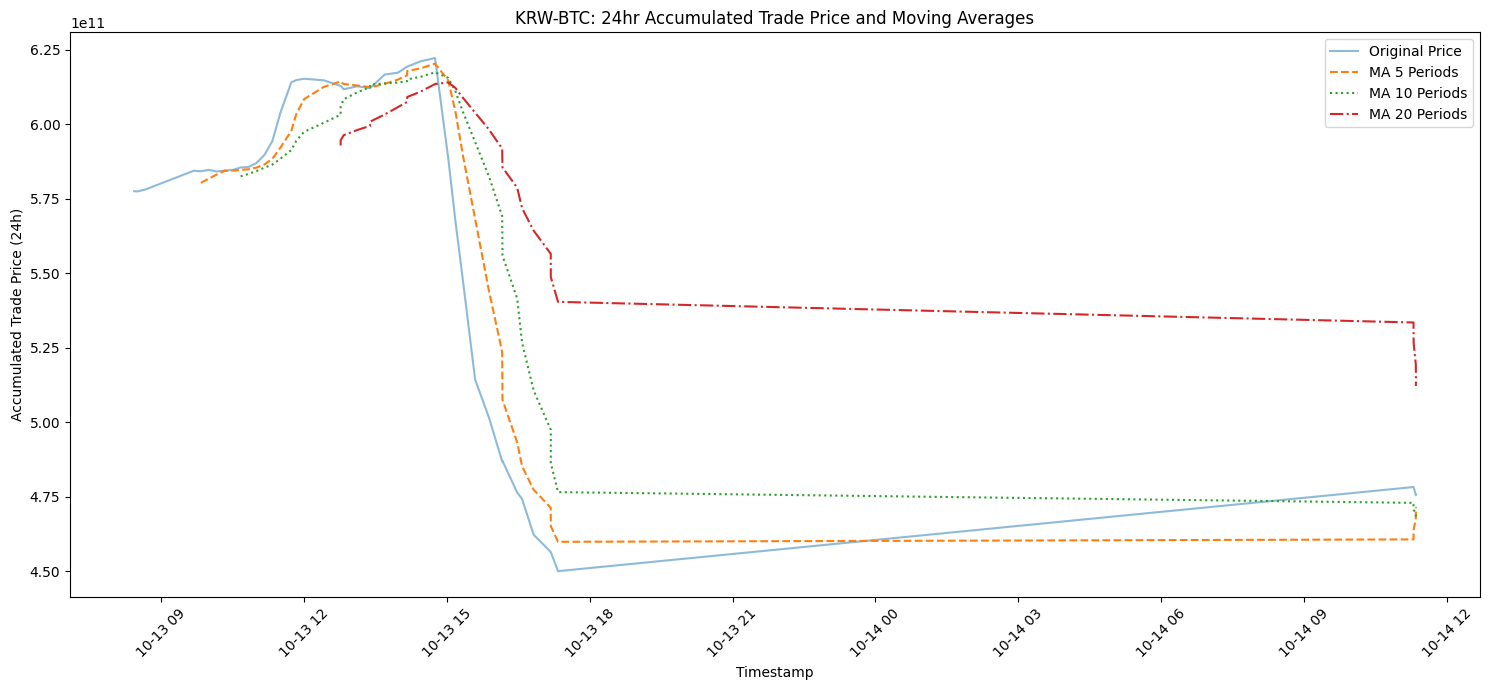

In [18]:
# 1. 이동 평균선 시각화
# 원본 데이터와 여러 이동 평균선을 함께 그려 추세를 비교합니다.

plt.figure(figsize=(15, 7)) # 그래프 크기 설정

# 원본 24시간 누적 거래대금 그리기
sns.lineplot(data=df_btc, x='ts_event', y='acc_trade_price_24h', label='Original Price', alpha=0.5)

# 이동 평균선들 그리기
sns.lineplot(data=df_btc, x='ts_event', y='price_MA5', label='MA 5 Periods', linestyle='--')
sns.lineplot(data=df_btc, x='ts_event', y='price_MA10', label='MA 10 Periods', linestyle=':')
sns.lineplot(data=df_btc, x='ts_event', y='price_MA20', label='MA 20 Periods', linestyle='-.')

plt.title('KRW-BTC: 24hr Accumulated Trade Price and Moving Averages')
plt.xlabel('Timestamp')
plt.ylabel('Accumulated Trade Price (24h)')
plt.xticks(rotation=45)
plt.legend() # 각 선이 무엇을 의미하는지 범례 표시
plt.tight_layout()
plt.show()

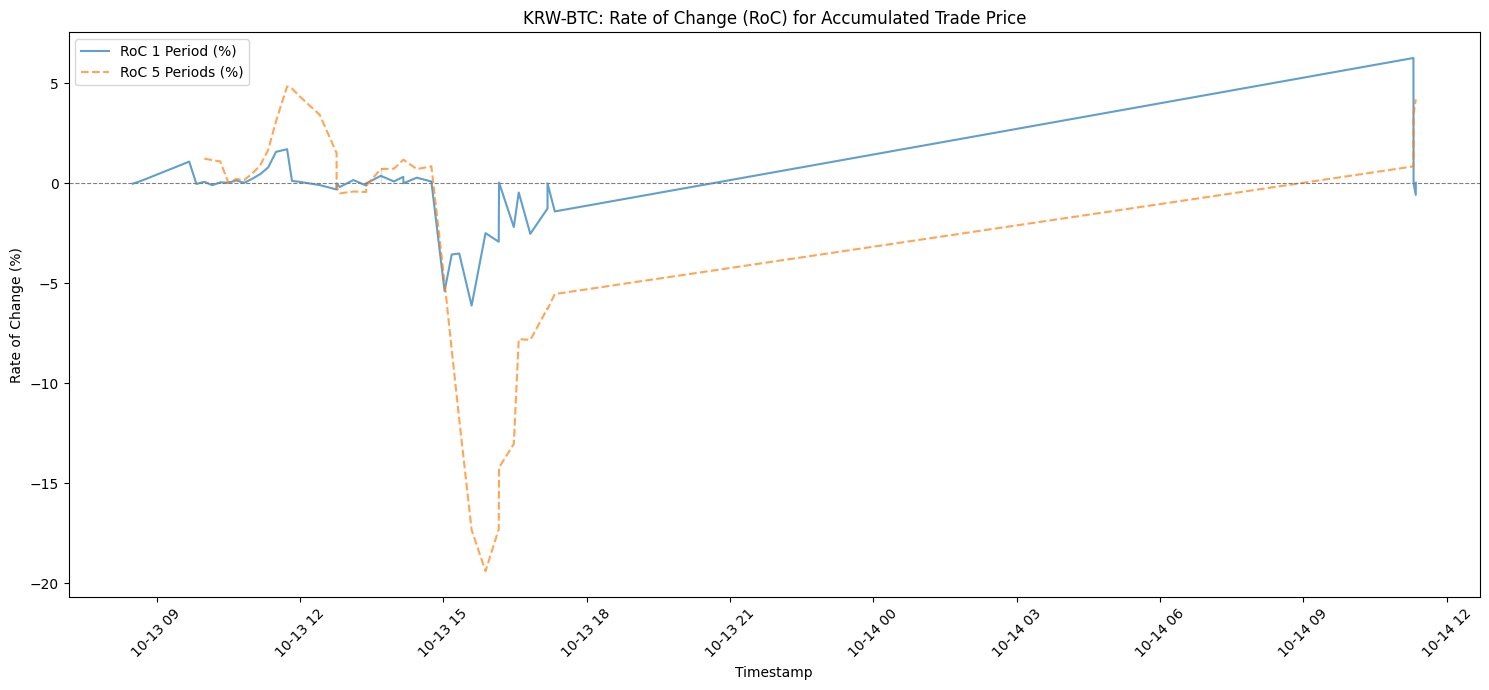

In [19]:
# 2. 변동률 시각화
# 단기(RoC1) 및 중기(RoC5) 가격 변동률의 추세를 확인합니다.

plt.figure(figsize=(15, 7))

# 변동률 선 그래프 그리기
sns.lineplot(data=df_btc, x='ts_event', y='price_RoC1', label='RoC 1 Period (%)', alpha=0.7)
sns.lineplot(data=df_btc, x='ts_event', y='price_RoC5', label='RoC 5 Periods (%)', alpha=0.7, linestyle='--')

# 0 기준선 추가 (변동이 없는 상태)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)

plt.title('KRW-BTC: Rate of Change (RoC) for Accumulated Trade Price')
plt.xlabel('Timestamp')
plt.ylabel('Rate of Change (%)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

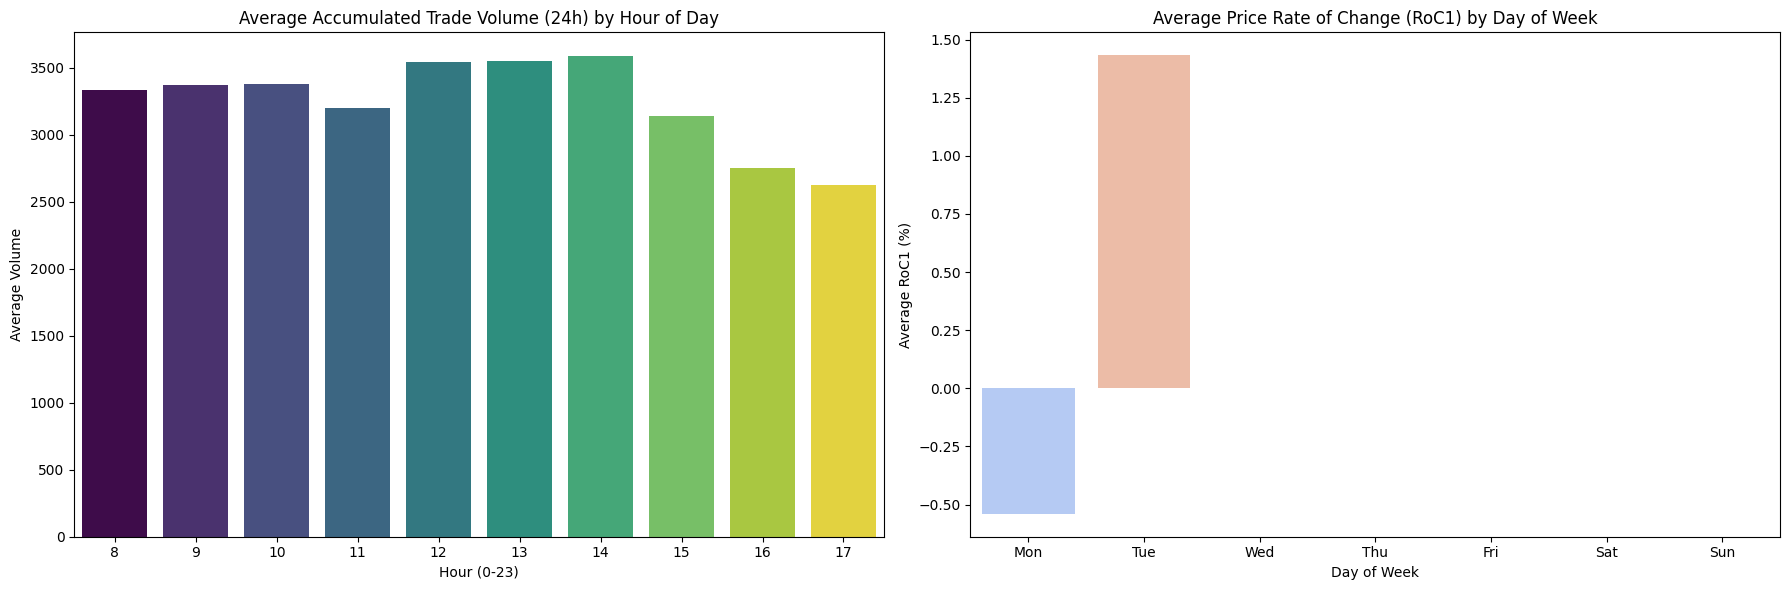

In [22]:
# 3. 시간대별 분석 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 시간대별 평균 거래량
hourly_volume = df_btc.groupby('hour_of_day')['acc_trade_volume_24h'].mean().reset_index()
# --- 수정된 부분 ---
sns.barplot(data=hourly_volume, x='hour_of_day', y='acc_trade_volume_24h', ax=axes[0],
            palette='viridis', hue='hour_of_day', legend=False) # hue와 legend=False 추가
# -------------------
axes[0].set_title('Average Accumulated Trade Volume (24h) by Hour of Day')
axes[0].set_xlabel('Hour (0-23)')
axes[0].set_ylabel('Average Volume')

# 요일별 평균 가격 변동률 (RoC1 기준)
daily_roc = df_btc.dropna(subset=['price_RoC1']).groupby('day_of_week')['price_RoC1'].mean().reset_index()
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
daily_roc['day_name'] = daily_roc['day_of_week'].map(day_map)

# --- 수정된 부분 ---
sns.barplot(data=daily_roc, x='day_name', y='price_RoC1', ax=axes[1],
            order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
            palette='coolwarm', hue='day_name', legend=False) # hue와 legend=False 추가
# -------------------
axes[1].set_title('Average Price Rate of Change (RoC1) by Day of Week')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Average RoC1 (%)')

plt.tight_layout()
plt.show()

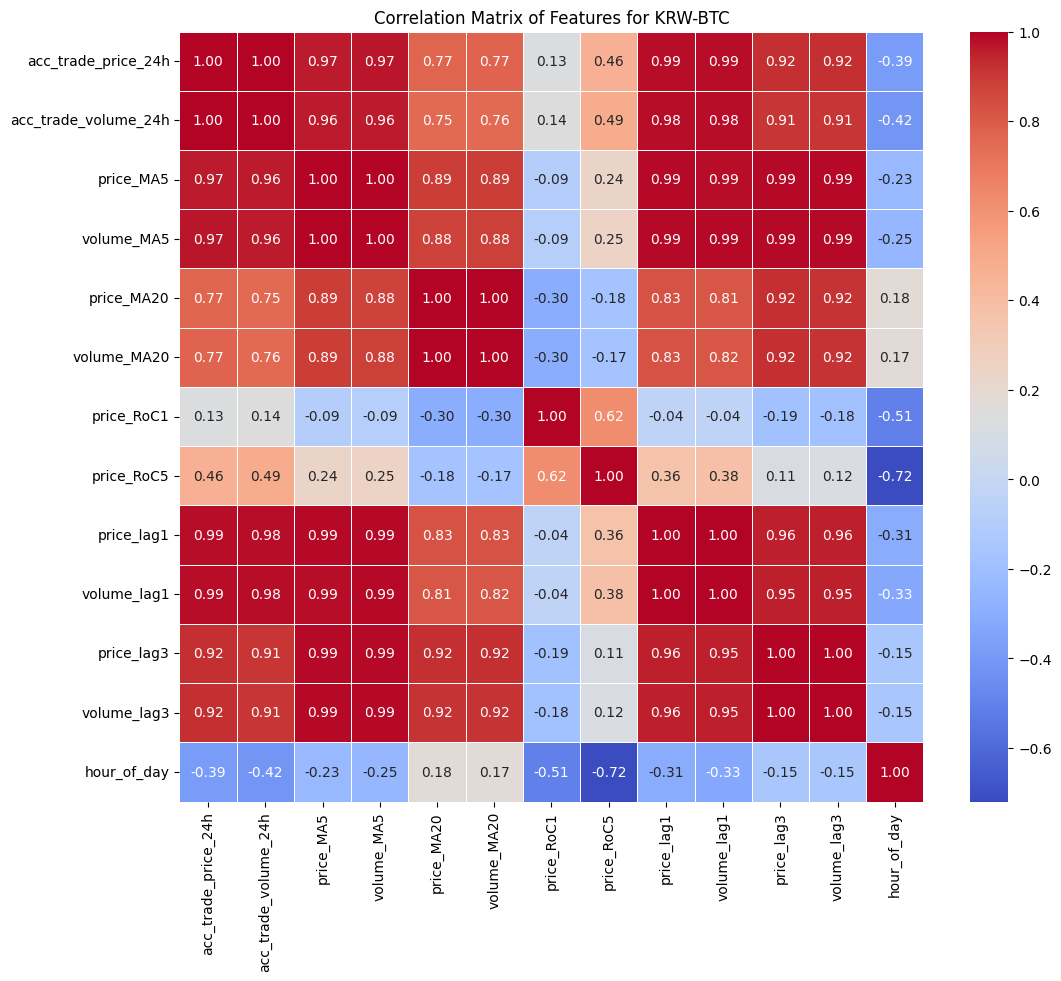

In [28]:
# 4. 상관 관계 분석 시각화 (Heatmap)
# 주요 숫자형 피처들 간의 상관 관계를 시각적으로 파악합니다.

# 상관 관계를 계산할 숫자형 컬럼들만 선택 (NaN 값 처리 후)
# 너무 많은 lag/ma 변수는 제외하고 주요 변수 위주로 선택
numeric_cols = [
    'acc_trade_price_24h', 'acc_trade_volume_24h',
    'price_MA5', 'volume_MA5', 'price_MA20', 'volume_MA20',
    'price_RoC1', 'price_RoC5',
    'price_lag1', 'volume_lag1', 'price_lag3', 'volume_lag3',
    'hour_of_day' # 시간대도 숫자형으로 포함 가능
]

# 계산 전 NaN 값 제거
df_corr = df_btc[numeric_cols].dropna()

# 상관 행렬 계산
correlation_matrix = df_corr.corr()

# 히트맵 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features for KRW-BTC')
plt.savefig('heatmap_krw_btc.png', bbox_inches='tight')
plt.show()